In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [4]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
dataset_fname = 'bursi.pos.gspan'
def get_graphs(size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [5]:
%%time
'''
induce a grammar and train an estimator
'''
from graphlearn.graphlearn import GraphLearnSampler
training_graphs = get_graphs(size=250)
sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],min_cip_count=2, min_interface_count=2)
sampler.fit(training_graphs,n_jobs=-1,batch_size=10)


Classifier:
SGDClassifier(alpha=0.000142221149546, average=False, class_weight=None,
       epsilon=0.1, eta0=0.367490543851, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=74, n_jobs=1,
       penalty='l1', power_t=0.386563527215, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
CPU times: user 14.5 s, sys: 932 ms, total: 15.4 s
Wall time: 26.1 s


preprocessing grammar
_sample_notes: 
_sample_path_score_set: set([0.25464920175002276, 0.14317822288337945, 0.18945975157199069, 0.2611927075498135, 0.27940292498913211, 0.090647118141574945])
_score_list: [0.14554390655547372, 0.14317822288337945, 0.13978369281472525, 0.14634447630078085, 0.10143108012808062, 0.094373716100904614, 0.10143108012808062, 0.10087638555959827, 0.19685495462220667, 0.17928310914133302, 0.08186350752148408, 0.090647118141574945, 0.090647118141574945, 0.12626805898519386, 0.15121452198448704, 0.20116090993306279, 0.20116090993306279, 0.20116090993306279, 0.20116090993306279, 0.22519663559702366, 0.22519663559702366, 0.2611927075498135, 0.2611927075498135, 0.2611927075498135, 0.2611927075498135, 0.2611927075498135, 0.2611927075498135, 0.21787050456821963, 0.21787050456821963, 0.21787050456821963, 0.21787050456821963, 0.21787050456821963, 0.21117704650162797, 0.17195814360568371, 0.18945975157199069, 0.18945975157199069, 0.18945975157199069, 0.1894597515719906

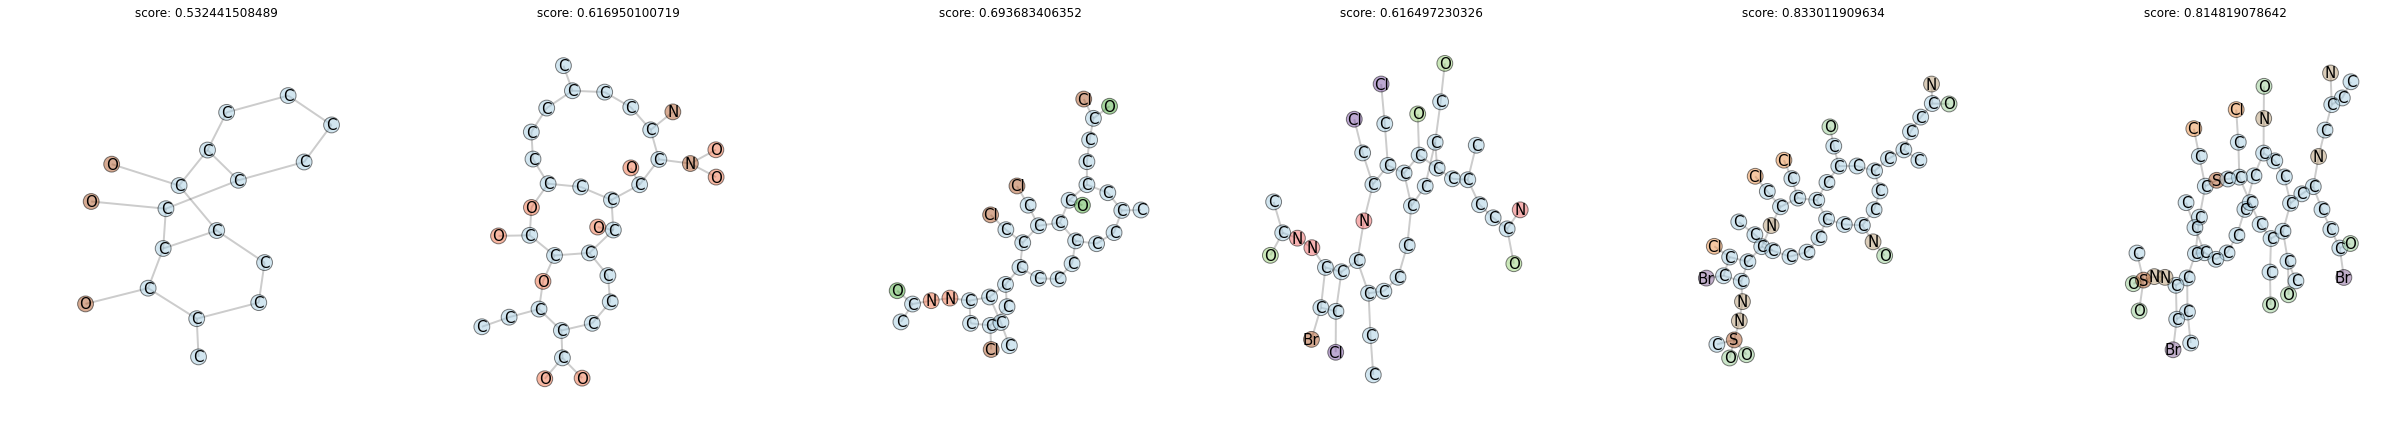

iteration:0
Working with 28 cores
iteration:1
Working with 25 cores
iteration:2
Working with 18 cores
iteration:3
Working with 1 cores
iteration:4
Working with 2 cores
iteration:5
Working with 1 cores
iteration:6
Working with 28 cores
iteration:7
Working with 1 cores
iteration:8
Working with 28 cores
iteration:9
Working with 28 cores
iteration:10
Working with 28 cores
iteration:11
Working with 8 cores
iteration:12
Working with 12 cores
iteration:13
Working with 28 cores
iteration:14
Working with 28 cores
iteration:15
Working with 28 cores
iteration:16
Working with 8 cores
iteration:17
Working with 28 cores
iteration:18
Working with 28 cores
iteration:19
Working with 28 cores
iteration:20
Working with 28 cores
iteration:21
Working with 17 cores
iteration:22
Working with 6 cores
iteration:23
Working with 6 cores
iteration:24
Working with 28 cores
iteration:25
Working with 18 cores
iteration:26
Working with 1 cores
iteration:27
Working with 6 cores
iteration:28
Working with 18 cores
itera

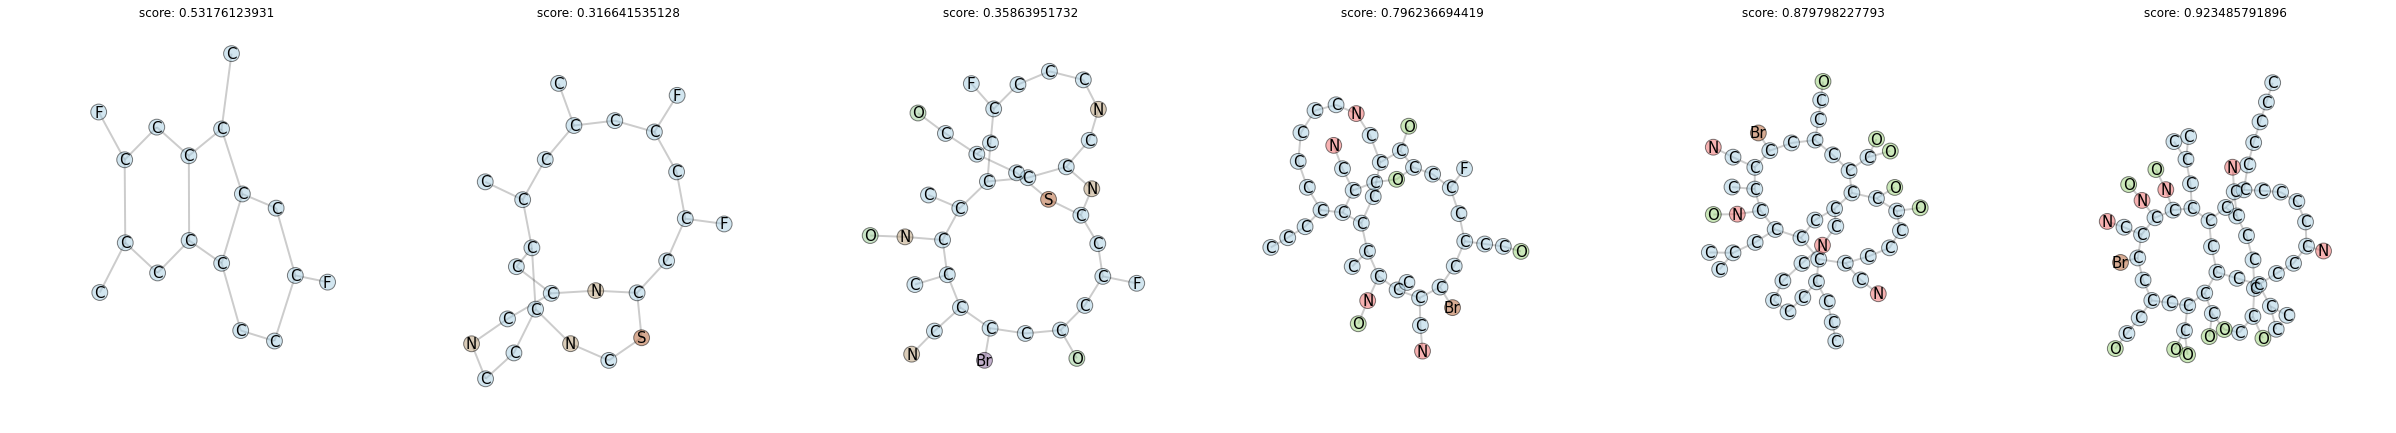

iteration:0
Working with 17 cores
iteration:1
Working with 8 cores
iteration:2
Working with 17 cores
iteration:3
Working with 9 cores
iteration:4
Working with 17 cores
iteration:5
Working with 28 cores
iteration:6
Working with 3 cores
iteration:7
Working with 25 cores
iteration:8
Working with 17 cores
iteration:9
Working with 28 cores
iteration:10
Working with 3 cores
iteration:11
Working with 6 cores
iteration:12
Working with 12 cores
iteration:13
Working with 25 cores
iteration:14
Working with 3 cores
iteration:15
Working with 12 cores
iteration:16
Working with 28 cores
iteration:17
Working with 12 cores
iteration:18
Working with 25 cores
iteration:19
Working with 28 cores
iteration:20
Working with 25 cores
iteration:21
Working with 17 cores
iteration:22
Working with 12 cores
iteration:23
Working with 28 cores
iteration:24
Working with 9 cores
iteration:25
Working with 3 cores
iteration:26
Working with 18 cores
iteration:27
Working with 9 cores
iteration:28
Working with 17 cores
iter

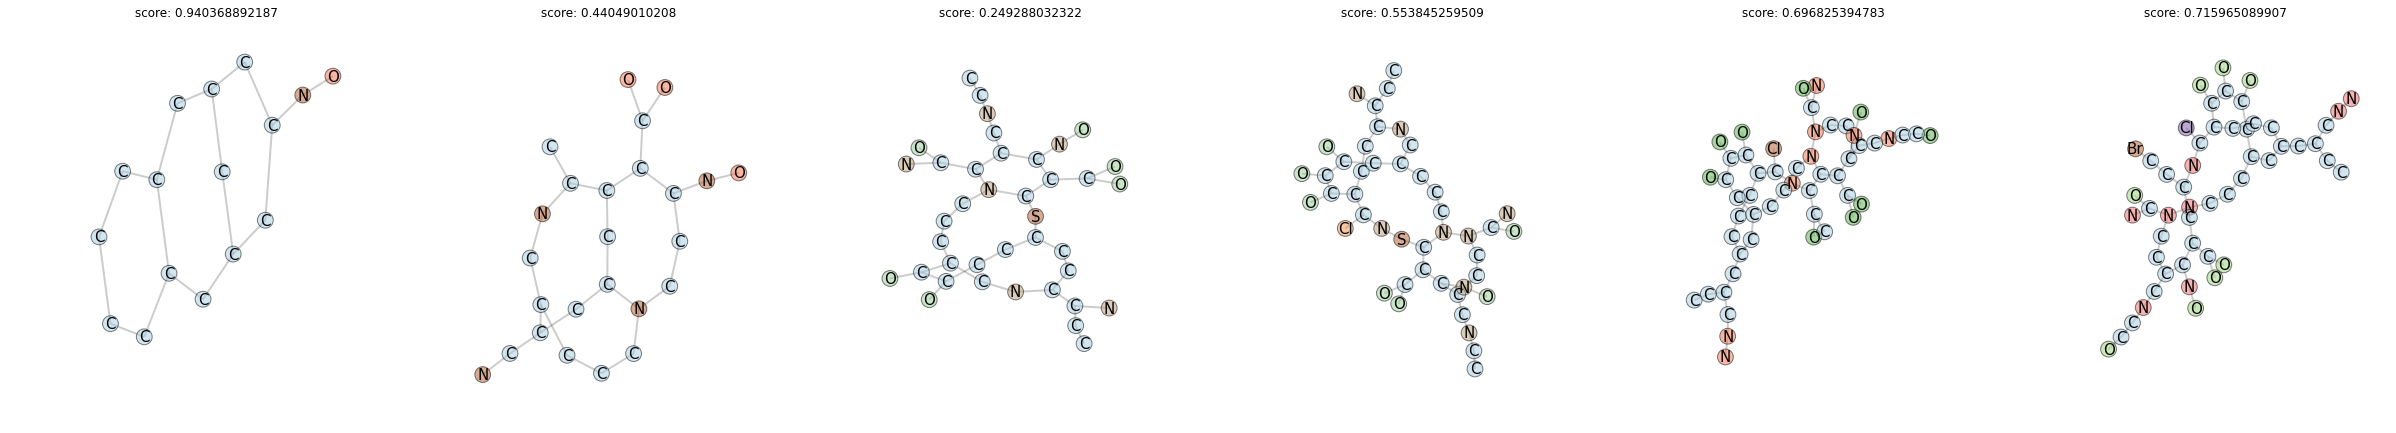

iteration:0
Working with 1 cores
iteration:1
Working with 3 cores
iteration:2
Working with 1 cores
iteration:3
Working with 28 cores
iteration:4
Working with 17 cores
iteration:5
Working with 6 cores
iteration:6
Working with 11 cores
iteration:7
Working with 28 cores
iteration:8
Working with 28 cores
iteration:9
Working with 9 cores
iteration:10
Working with 28 cores
iteration:11
Working with 12 cores
iteration:12
Working with 8 cores
iteration:13
Working with 5 cores
iteration:14
Working with 9 cores
iteration:15
Working with 17 cores
iteration:16
Working with 25 cores
iteration:17
Working with 12 cores
iteration:18
Working with 25 cores
iteration:19
Working with 8 cores
iteration:20
Working with 3 cores
iteration:21
Working with 17 cores
iteration:22
Working with 10 cores
iteration:23
Working with 2 cores
iteration:24
Working with 25 cores
iteration:25
Working with 2 cores
iteration:26
Working with 17 cores
iteration:27
Working with 8 cores
iteration:28
Working with 2 cores
iteration

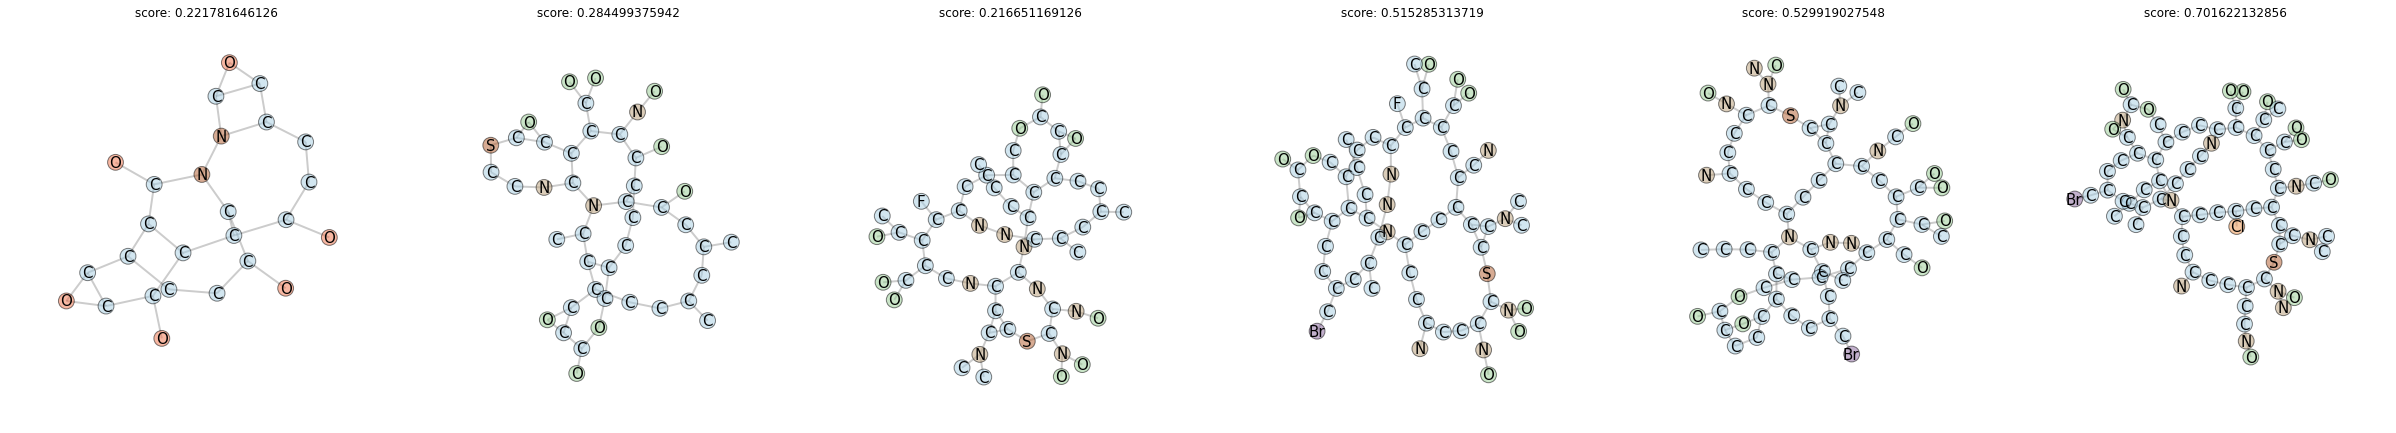

iteration:0
Working with 12 cores
iteration:1
Working with 8 cores
iteration:2
Working with 3 cores
iteration:3
Working with 2 cores
iteration:4
Working with 28 cores
iteration:5
Working with 2 cores
iteration:6
Working with 1 cores
iteration:7
Working with 2 cores
iteration:8
Working with 3 cores
iteration:9
Working with 28 cores
iteration:10
Working with 17 cores
iteration:11
Working with 2 cores
iteration:12
Working with 1 cores
iteration:13
Working with 28 cores
iteration:14
Working with 25 cores
iteration:15
Working with 25 cores
iteration:16
Working with 2 cores
iteration:17
Working with 12 cores
iteration:18
Working with 9 cores
iteration:19
Working with 2 cores
iteration:20
Working with 17 cores
iteration:21
Working with 2 cores
iteration:22
Working with 28 cores
iteration:23
Working with 25 cores
iteration:24
Working with 17 cores
iteration:25
Working with 17 cores
iteration:26
Working with 17 cores
iteration:27
Working with 17 cores
iteration:28
Working with 25 cores
iteratio

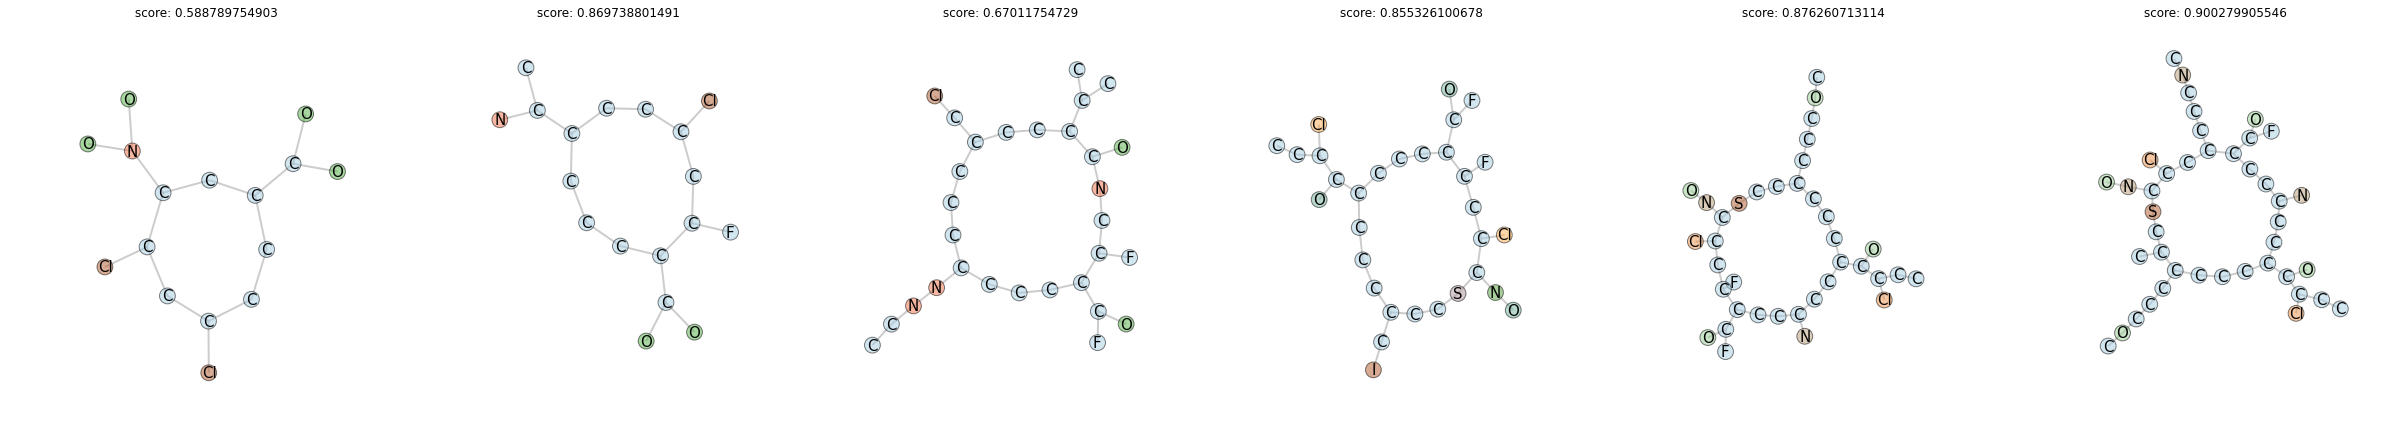

iteration:0
Working with 28 cores
iteration:1
Working with 28 cores
iteration:2
Working with 28 cores
iteration:3
Working with 28 cores
iteration:4
Working with 28 cores
iteration:5
Working with 28 cores
iteration:6
Working with 25 cores
iteration:7
Working with 28 cores
iteration:8
Working with 28 cores
iteration:9
Working with 28 cores
iteration:10
Working with 17 cores
iteration:11
Working with 28 cores
iteration:12
Working with 17 cores
iteration:13
Working with 17 cores
iteration:14
Working with 28 cores
iteration:15
Working with 6 cores
iteration:16
Working with 25 cores
iteration:17
Working with 28 cores
iteration:18
Working with 28 cores
iteration:19
Working with 28 cores
iteration:20
Working with 28 cores
iteration:21
Working with 28 cores
iteration:22
Working with 28 cores
iteration:23
Working with 25 cores
iteration:24
Working with 25 cores
iteration:25
Working with 28 cores
iteration:26
Working with 12 cores
iteration:27
Working with 6 cores
iteration:28
Working with 17 cor

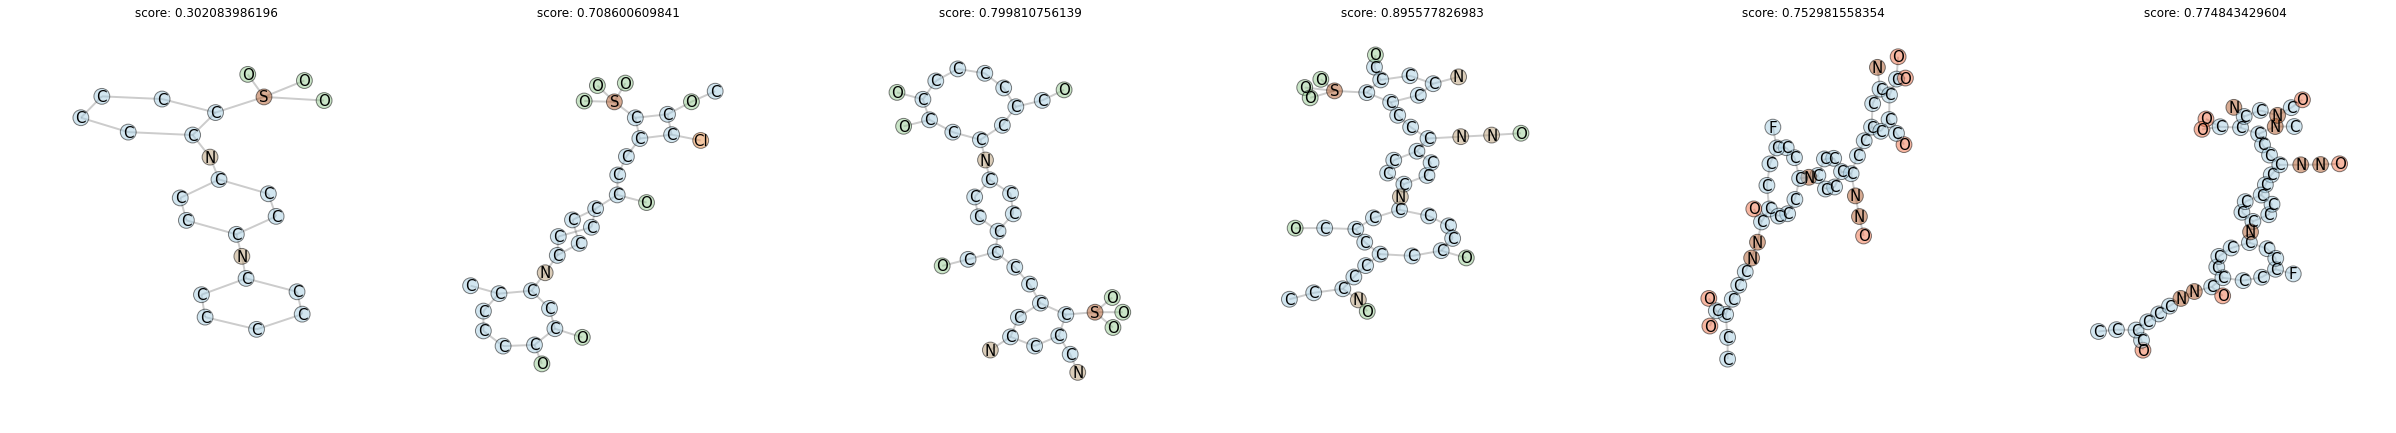

iteration:0
Working with 18 cores
iteration:1
Working with 25 cores
iteration:2
Working with 2 cores
iteration:3
Working with 13 cores
iteration:4
Working with 2 cores
iteration:5
Working with 2 cores
iteration:6
Working with 13 cores
iteration:7
Working with 25 cores
iteration:8
Working with 5 cores
iteration:9
Working with 28 cores
iteration:10
Working with 28 cores
iteration:11
Working with 2 cores
iteration:12
Working with 13 cores
iteration:13
Working with 17 cores
iteration:14
Working with 5 cores
iteration:15
Working with 13 cores
iteration:16
Working with 17 cores
iteration:17
Working with 11 cores
iteration:18
Working with 1 cores
iteration:19
Working with 13 cores
iteration:20
Working with 13 cores
iteration:21
Working with 4 cores
iteration:22
Working with 17 cores
iteration:23
Working with 8 cores
iteration:24
Working with 17 cores
iteration:25
Working with 12 cores
iteration:26
Working with 2 cores
iteration:27
Working with 4 cores
iteration:28
Working with 12 cores
iterat

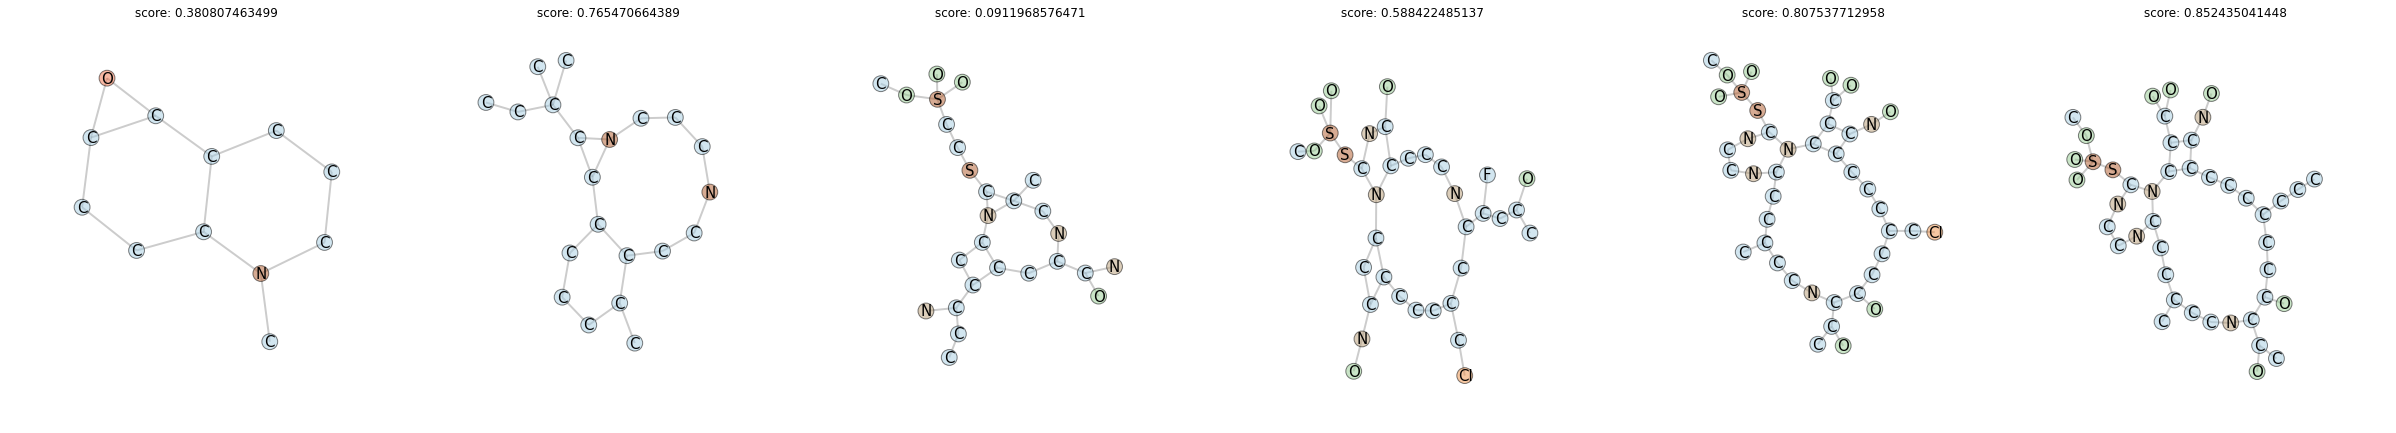

iteration:0
Working with 6 cores
iteration:1
Working with 17 cores
iteration:2
Working with 17 cores
iteration:3
Working with 28 cores
iteration:4
Working with 28 cores
iteration:5
Working with 12 cores
iteration:6
Working with 12 cores
iteration:7
Working with 25 cores
iteration:8
Working with 17 cores
iteration:9
Working with 7 cores
iteration:10
Working with 4 cores
iteration:11
Working with 25 cores
iteration:12
Working with 28 cores
iteration:13
Working with 28 cores
iteration:14
Working with 25 cores
iteration:15
Working with 25 cores
iteration:16
Working with 13 cores
iteration:17
Working with 7 cores
iteration:18
Working with 25 cores
iteration:19
Working with 17 cores
iteration:20
Working with 7 cores
iteration:21
Working with 17 cores
iteration:22
Working with 11 cores
iteration:23
Working with 10 cores
iteration:24
Working with 7 cores
iteration:25
Working with 26 cores
iteration:26
Working with 12 cores
iteration:27
Working with 4 cores
iteration:28
Working with 7 cores
ite

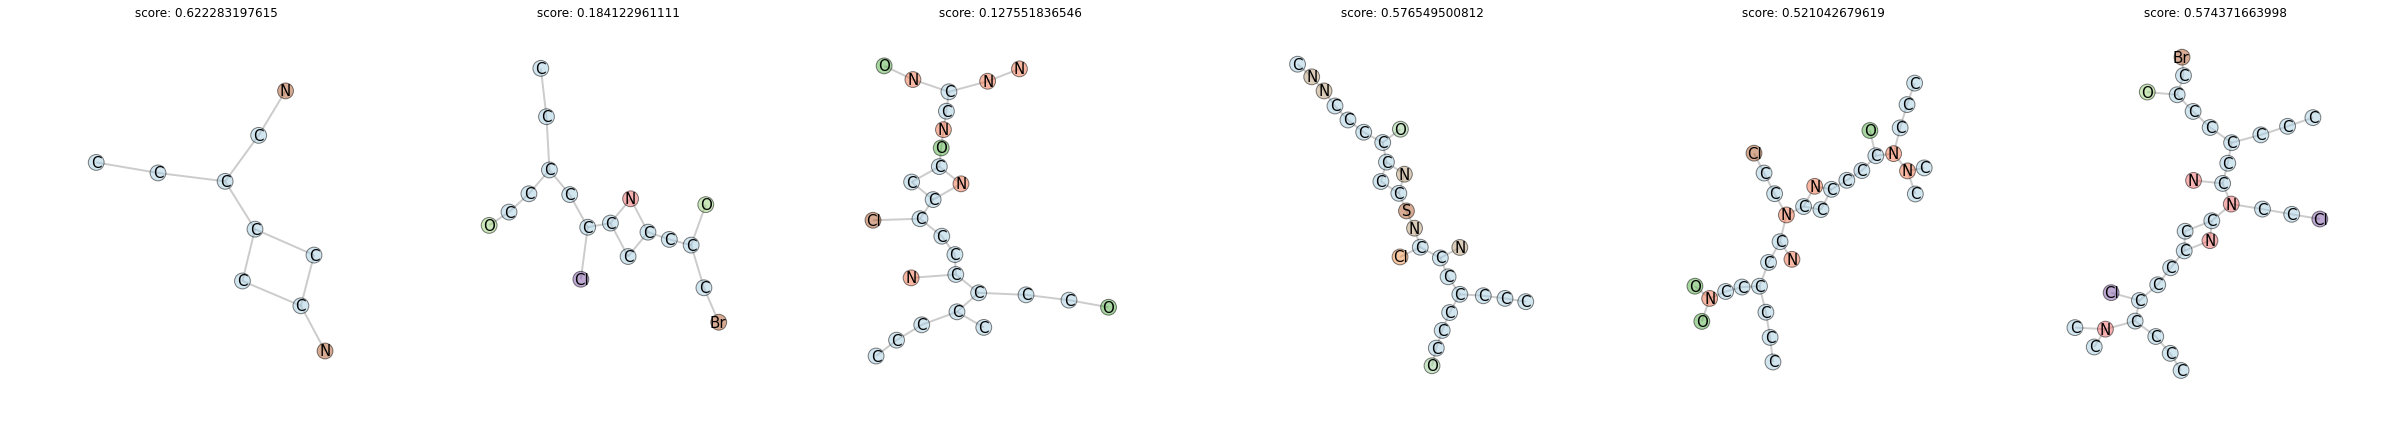

iteration:0
Working with 25 cores
iteration:1
Working with 25 cores
iteration:2
Working with 12 cores
iteration:3
Working with 25 cores
iteration:4
Working with 3 cores
iteration:5
Working with 7 cores
iteration:6
Working with 25 cores
iteration:7
Working with 3 cores
iteration:8
Working with 2 cores
iteration:9
Working with 3 cores
iteration:10
Working with 17 cores
iteration:11
Working with 12 cores
iteration:12
Working with 3 cores
iteration:13
Working with 28 cores
iteration:14
Working with 28 cores
iteration:15
Working with 1 cores
iteration:16
Working with 6 cores
iteration:17
Working with 3 cores
iteration:18
Working with 28 cores
iteration:19
Working with 25 cores
iteration:20
Working with 2 cores
iteration:21
Working with 28 cores
iteration:22
Working with 3 cores
iteration:23
Working with 7 cores
iteration:24
Working with 2 cores
iteration:25
Working with 12 cores
iteration:26
Working with 28 cores
iteration:27
Working with 17 cores
iteration:28
Working with 17 cores
iteratio

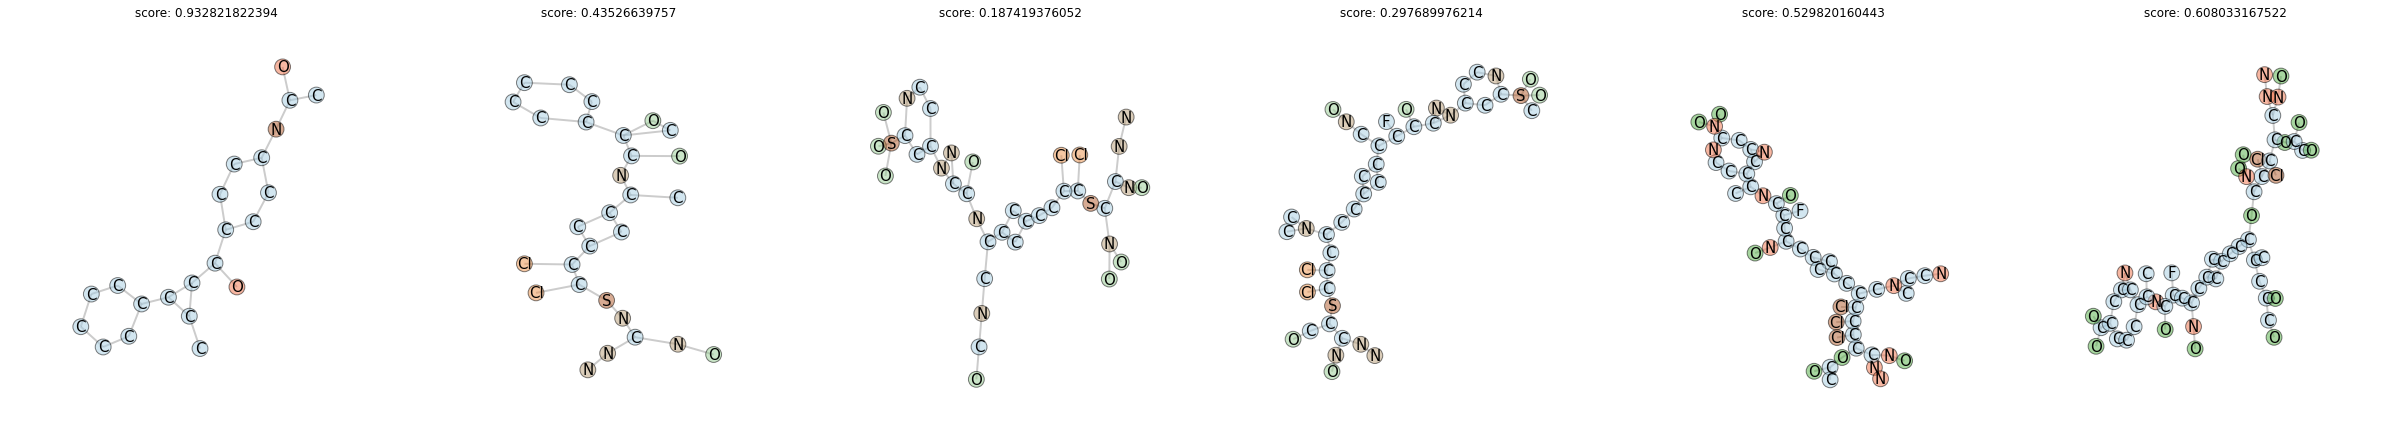

iteration:0
Working with 28 cores
iteration:1
Working with 12 cores
iteration:2
Working with 28 cores
iteration:3
Working with 12 cores
iteration:4
Working with 13 cores
iteration:5
Working with 29 cores
iteration:6
Working with 7 cores
iteration:7
Working with 3 cores
iteration:8
Working with 17 cores
iteration:9
Working with 7 cores
iteration:10
Working with 17 cores
iteration:11
Working with 28 cores
iteration:12
Working with 2 cores
iteration:13
Working with 28 cores
iteration:14
Working with 28 cores
iteration:15
Working with 28 cores
iteration:16
Working with 12 cores
iteration:17
Working with 28 cores
iteration:18
Working with 17 cores
iteration:19
Working with 28 cores
iteration:20
Working with 28 cores
iteration:21
Working with 3 cores
iteration:22
Working with 28 cores
iteration:23
Working with 12 cores
iteration:24
Working with 28 cores
iteration:25
Working with 3 cores
iteration:26
Working with 25 cores
iteration:27
Working with 17 cores
iteration:28
Working with 11 cores
i

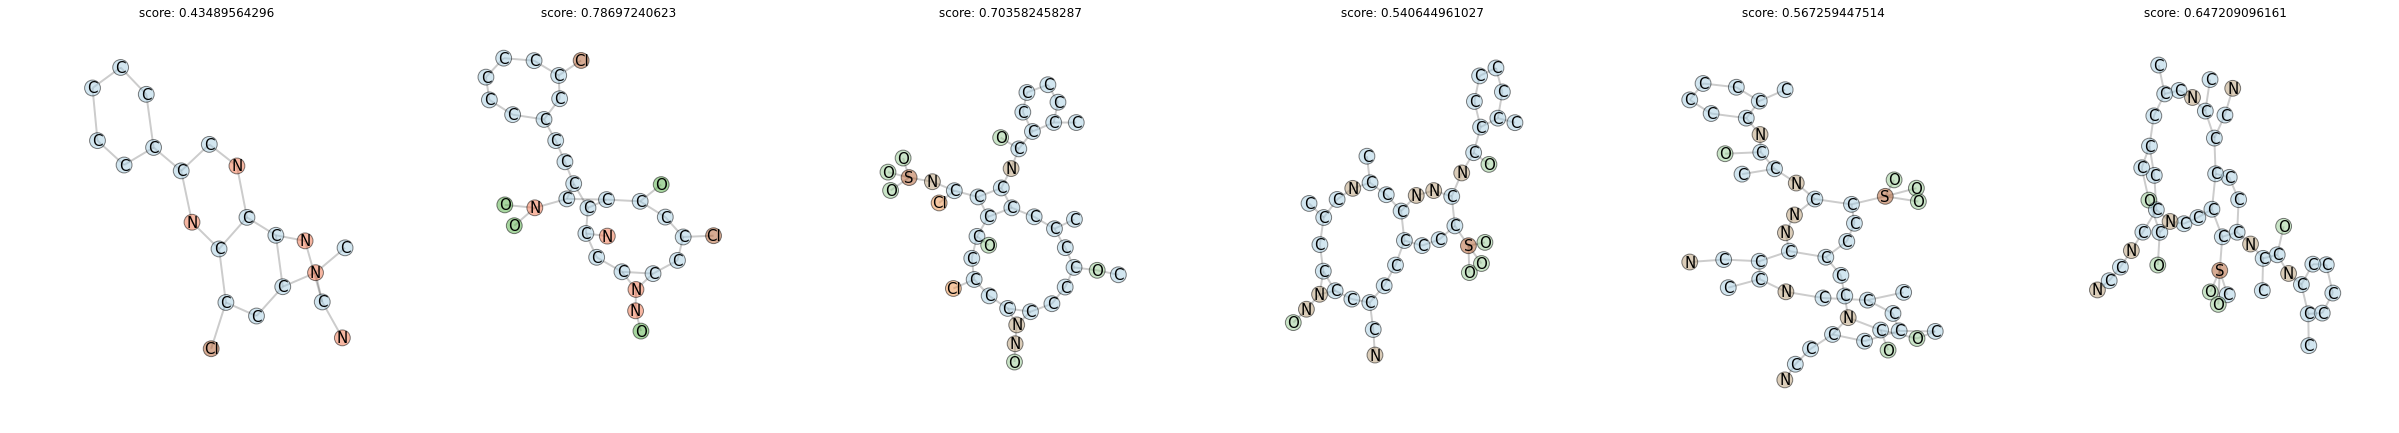

iteration:0
Working with 25 cores
iteration:1
Working with 1 cores
iteration:2
Working with 26 cores
iteration:3
Working with 7 cores
iteration:4
Working with 2 cores
iteration:5
Working with 25 cores
iteration:6
Working with 4 cores
iteration:7
Working with 7 cores
iteration:8
Working with 9 cores
iteration:9
Working with 2 cores
iteration:10
Working with 12 cores
iteration:11
Working with 7 cores
iteration:12
Working with 4 cores
iteration:13
Working with 3 cores
iteration:14
Working with 25 cores
iteration:15
Working with 25 cores
iteration:16
Working with 17 cores
iteration:17
Working with 6 cores
iteration:18
Working with 11 cores
iteration:19
Working with 17 cores
iteration:20
Working with 10 cores
iteration:21
Working with 3 cores
iteration:22
Working with 2 cores
iteration:23
Working with 28 cores
iteration:24
Working with 1 cores
iteration:25
Working with 29 cores
iteration:26
Working with 12 cores
iteration:27
Working with 1 cores
iteration:28
Working with 10 cores
iteration:

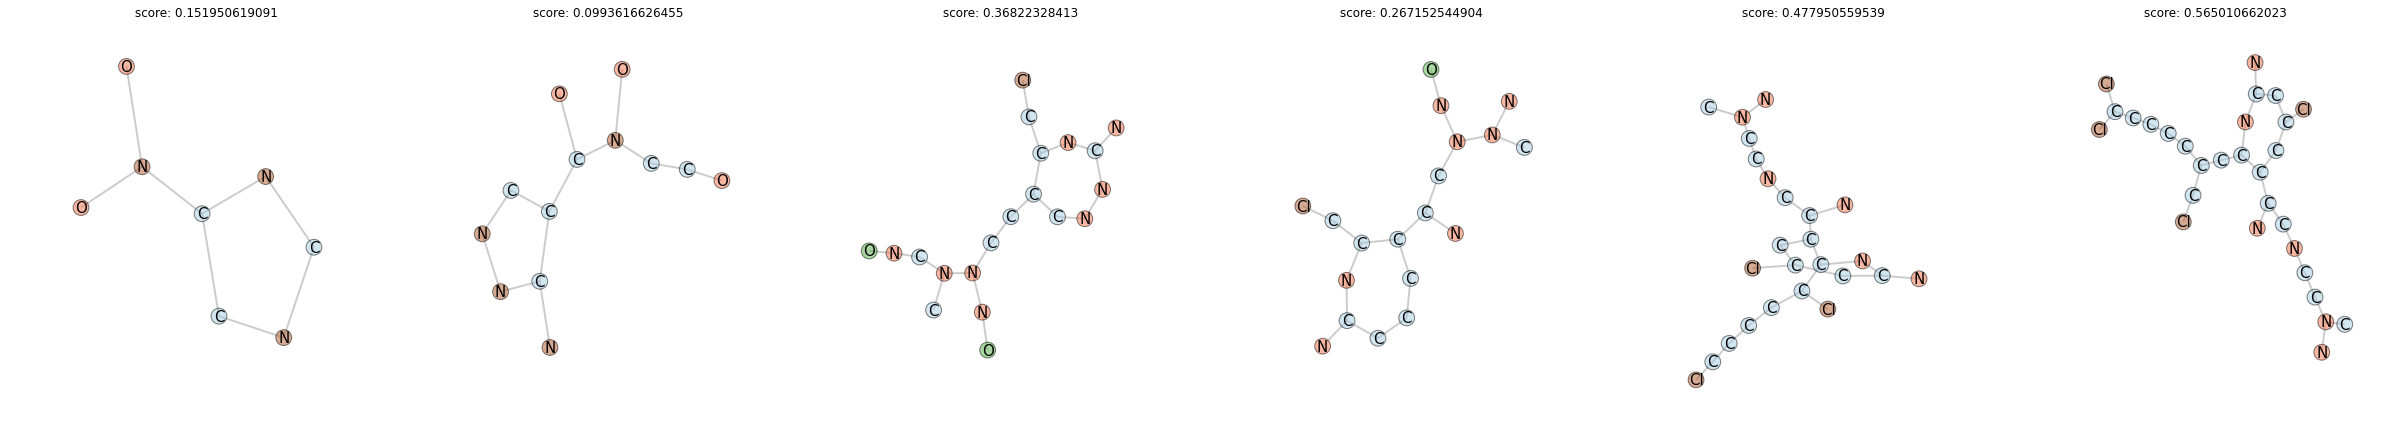

iteration:0
Working with 7 cores
iteration:1
Working with 6 cores
iteration:2
Working with 1 cores
iteration:3
Working with 11 cores
iteration:4
Working with 28 cores
iteration:5
Working with 2 cores
iteration:6
Working with 2 cores
iteration:7
Working with 17 cores
iteration:8
Working with 11 cores
iteration:9
Working with 25 cores
iteration:10
Working with 25 cores
iteration:11
Working with 25 cores
iteration:12
Working with 2 cores
iteration:13
Working with 2 cores
iteration:14
Working with 6 cores
iteration:15
Working with 2 cores
iteration:16
Working with 1 cores
iteration:17
Working with 9 cores
iteration:18
Working with 25 cores
iteration:19
Working with 17 cores
iteration:20
Working with 1 cores
iteration:21
Working with 7 cores
iteration:22
Working with 2 cores
iteration:23
Working with 28 cores
iteration:24
Working with 13 cores
iteration:25
Working with 28 cores
iteration:26
Working with 11 cores
iteration:27
Working with 2 cores
iteration:28
Working with 6 cores
iteration:2

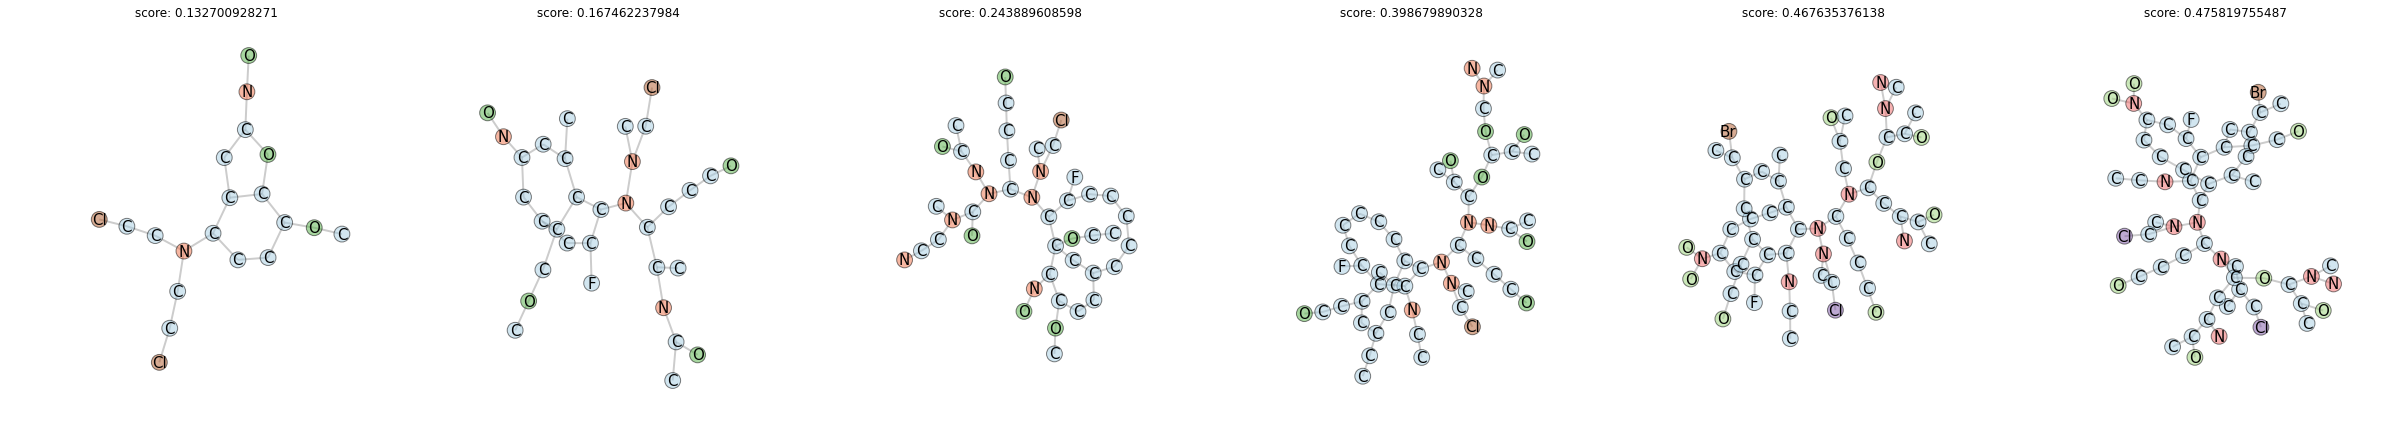

CPU times: user 1min 1s, sys: 2.13 s, total: 1min 3s
Wall time: 1min 6s


In [8]:
%%time
'''
Graph sampling
'''
graphs = get_graphs(size=100)
id_start=50
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)
n_steps=60
sampler.feasibility_checker.draw_problem=False
graphs = sampler.sample(graphs,
                        same_core_size=False,
                        n_samples=6,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=0.9,
                        probabilistic_core_choice=False,
                        burn_in=0,
                        select_cip_max_tries=200,
                        keep_duplicates=False)

from graphlearn.utils.draw import graphlearn_draw, get_score_of_graph
from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook=get_score_of_graph)

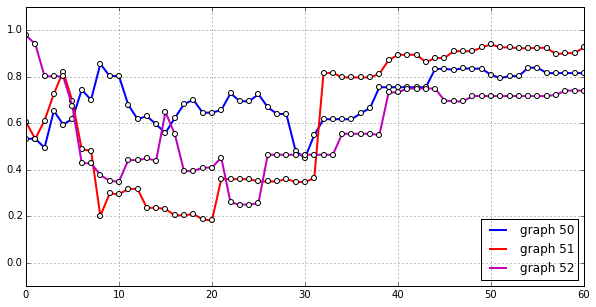

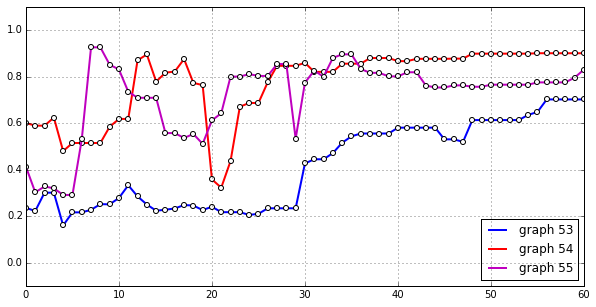

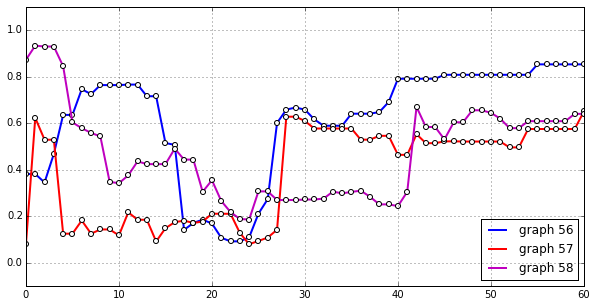

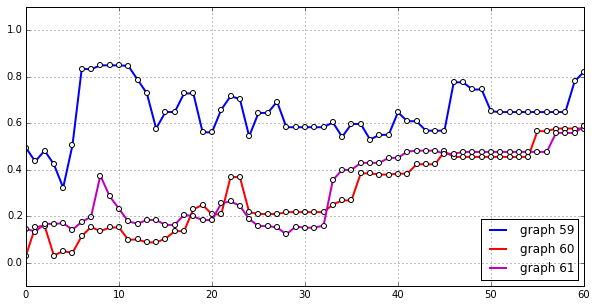

In [9]:
from itertools import islice
import numpy as np
import pylab as plt
step=n_steps
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=1,markersize=5)
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()